In [132]:
import pandas as pd
df = pd.read_csv('Data/Stroke.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [134]:
print("Raw Counts")
print(df['stroke'].value_counts())
print()
print('Percentages')
print(df['stroke'].value_counts(normalize=True))

Raw Counts
0    4861
1     249
Name: stroke, dtype: int64

Percentages
0    0.951272
1    0.048728
Name: stroke, dtype: float64


<AxesSubplot:xlabel='stroke', ylabel='count'>

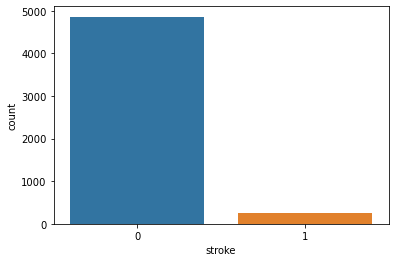

In [135]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.countplot(df['stroke'])

In [136]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [137]:
df['bmi'] = df['bmi'].fillna(df.bmi.mean())
df['bmi'] = df['bmi'].round(decimals=1)
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [138]:
df.groupby('stroke').mean()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi
stroke,,,,,,
0,36487.236371,41.971545,0.088871,0.047110,104.795513,28.825612
1,37115.068273,67.728193,0.265060,0.188755,132.544739,30.218876


In [139]:
"""The mean age of people with stroke is around 67 years, they more likely to have hypertension and heart disease, their average glucose level and bmi is higher"""

'The mean age of people with stroke is around 67 years, they more likely to have hypertension and heart disease, their average glucose level and bmi is higher'

Percentage of Stroke Occurence Based on Gender:
gender
Female    4.709419
Male      5.106383
Other     0.000000
Name: stroke, dtype: float64



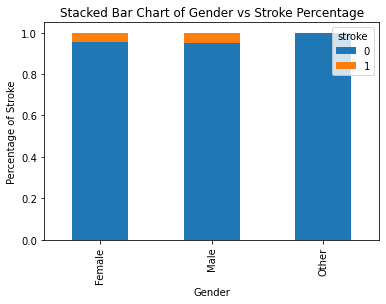

In [140]:
print("Percentage of Stroke Occurence Based on Gender:")
print(df.groupby('gender')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.gender, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Gender vs Stroke Percentage')
plt.xlabel('Gender')
plt.ylabel('Percentage of Stroke')
plt.savefig('gender_vs_stroke')

Percentage of Stroke Occurence Based on Marital Status:
ever_married
No     1.650541
Yes    6.561288
Name: stroke, dtype: float64



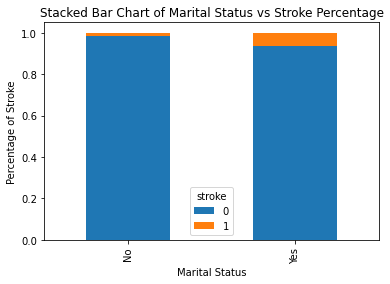

In [141]:
print("Percentage of Stroke Occurence Based on Marital Status:")
print(df.groupby('ever_married')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.ever_married, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Stroke Percentage')
plt.xlabel('Marital Status')
plt.ylabel('Percentage of Stroke')
plt.savefig('marriage_vs_stroke')

Percentage of Stroke Occurence Based on Work Type:
work_type
Govt_job         5.022831
Never_worked     0.000000
Private          5.094017
Self-employed    7.936508
children         0.291121
Name: stroke, dtype: float64



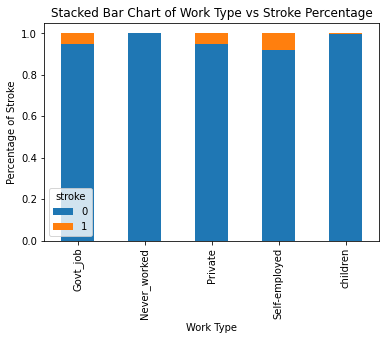

In [142]:
print("Percentage of Stroke Occurence Based on Work Type:")
print(df.groupby('work_type')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.work_type, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Work Type vs Stroke Percentage')
plt.xlabel('Work Type')
plt.ylabel('Percentage of Stroke')
plt.savefig('work_vs_stroke')

Percentage of Stroke Occurence Based on Residence Type:
Residence_type
Rural    4.534606
Urban    5.200308
Name: stroke, dtype: float64



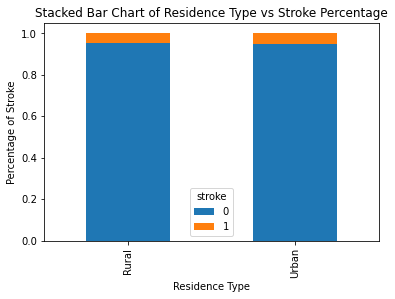

In [143]:
print("Percentage of Stroke Occurence Based on Residence Type:")
print(df.groupby('Residence_type')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.Residence_type, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Residence Type vs Stroke Percentage')
plt.xlabel('Residence Type')
plt.ylabel('Percentage of Stroke')
plt.savefig('residence_vs_stroke')

Percentage of Stroke Occurence Based on Smoking Status:
smoking_status
Unknown            3.044041
formerly smoked    7.909605
never smoked       4.756871
smokes             5.323194
Name: stroke, dtype: float64



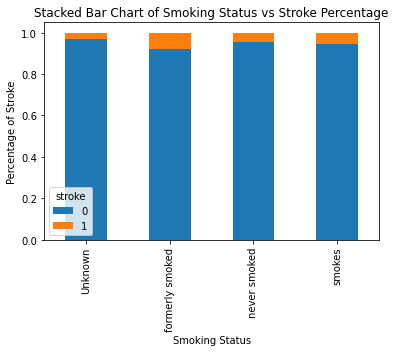

In [144]:
print("Percentage of Stroke Occurence Based on Smoking Status:")
print(df.groupby('smoking_status')['stroke'].mean() * 100)
print()
table = pd.crosstab(df.smoking_status, df.stroke)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Smoking Status vs Stroke Percentage')
plt.xlabel('Smoking Status')
plt.ylabel('Percentage of Stroke')
plt.savefig('smoking_vs_stroke')

In [145]:
"""As seen from the abpve charts, the parameters that influence on whether a person will have a stroke are: marital status, work type and smoking status"""

'As seen from the abpve charts, the parameters that influence on whether a person will have a stroke are: marital status, work type and smoking status'

In [146]:
df['gender'] = df['gender'].replace({'Female': 0, 'Male': 1, 'Other': 2}).astype('int8')
df['ever_married'] = df['ever_married'].replace({'No': 0, 'Yes': 1}).astype('int8')
df['Residence_type'] = df['Residence_type'].replace({'Urban': 0, 'Rural': 1}).astype('int8')

In [147]:
df = pd.get_dummies(df, columns=['work_type', 'smoking_status'])
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,1,67.0,0,1,1,0,228.69,36.6,1,0,0,1,0,0,0,1,0,0
1,51676,0,61.0,0,0,1,1,202.21,28.9,1,0,0,0,1,0,0,0,1,0
2,31112,1,80.0,0,1,1,1,105.92,32.5,1,0,0,1,0,0,0,0,1,0
3,60182,0,49.0,0,0,1,0,171.23,34.4,1,0,0,1,0,0,0,0,0,1
4,1665,0,79.0,1,0,1,1,174.12,24.0,1,0,0,0,1,0,0,0,1,0


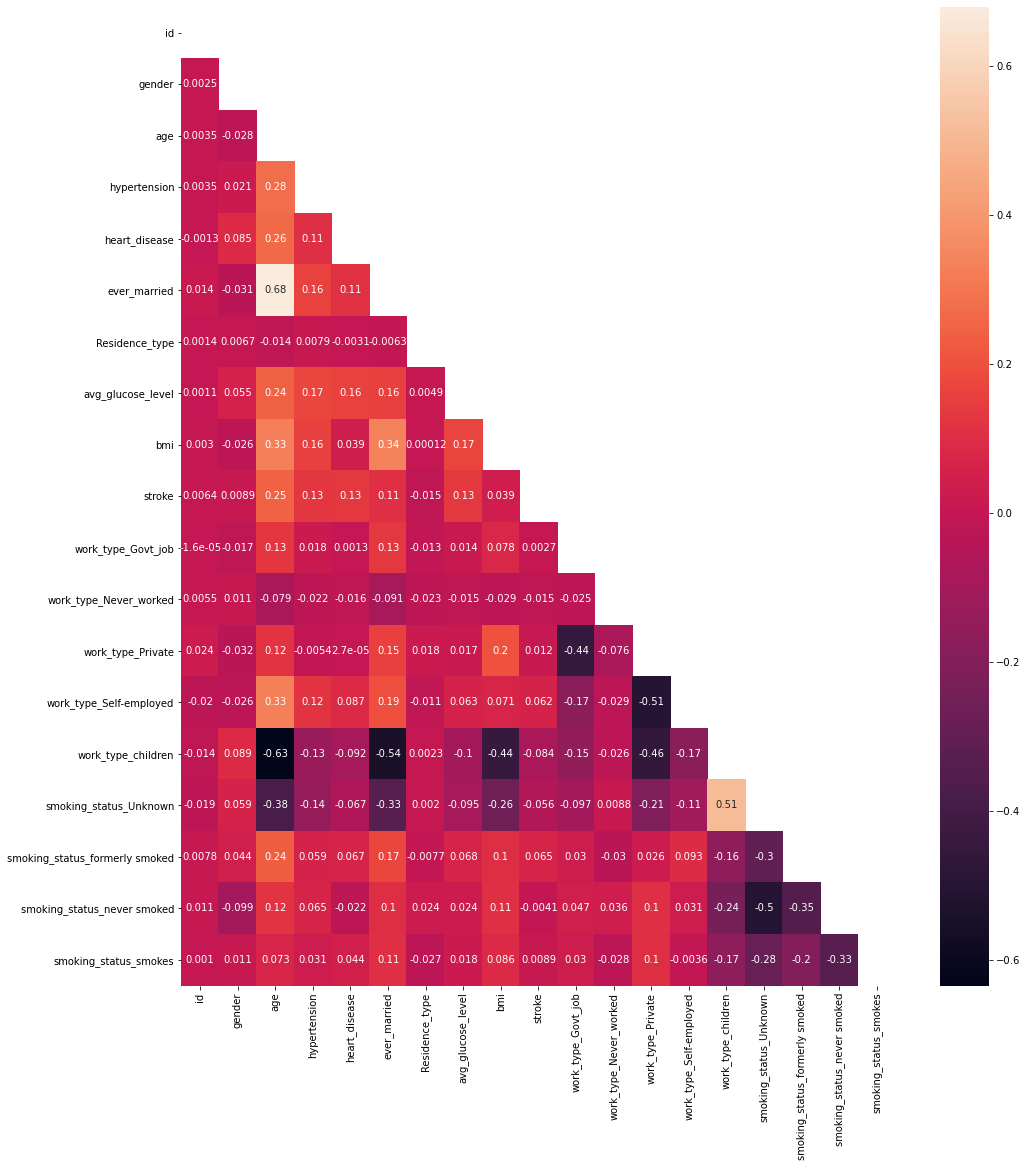

In [148]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
corr = df.corr()
fig, ax = plt.subplots(figsize = (16, 18))
sns.heatmap(data = corr, 
            mask = np.triu(np.ones_like(corr, dtype = bool)), 
            ax = ax, 
            annot = True);

In [160]:
y = df['stroke']
X = df.drop(columns=['id', 'stroke'], axis=1)

In [161]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
print(y_train.value_counts(),'\n\n', y_test.value_counts())

0    3645
1     187
Name: stroke, dtype: int64 

 0    1216
1      62
Name: stroke, dtype: int64


In [151]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import make_scorer, log_loss

neg_log_loss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
def custom_cross_val_score(estimator, X, y):
    kfold_train_scores = np.ndarray(5)
    kfold_val_scores = np.ndarray(5)
    kfold = StratifiedKFold()
    for fold, (train_index, val_index) in enumerate(kfold.split(X, y)):
        X_t, X_val = X.iloc[train_index], X.iloc[val_index]
        y_t, y_val = y.iloc[train_index], y.iloc[val_index]
        temp_model = clone(estimator)
        temp_model.fit(X_t, y_t)
        neg_log_loss_score_train = neg_log_loss(temp_model, X_t, y_t)
        neg_log_loss_score_val = neg_log_loss(temp_model, X_val, y_val)
        kfold_train_scores[fold] = neg_log_loss_score_train
        kfold_val_scores[fold] = neg_log_loss_score_val
    return kfold_train_scores, kfold_val_scores

In [152]:
logreg_baseline_model = LogisticRegression(random_state=42)
train_scores, neg_log_loss_cv = custom_cross_val_score(
    logreg_baseline_model,
    X_train,
    y_train)
print("Train:", -train_scores.mean())
print("Validation:", -neg_log_loss_cv.mean())

Train: 0.15606768906852625
Validation: 0.15781368105278087


In [153]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

def print_metrics(labels, preds):
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))

In [154]:
logreg_baseline_model.fit(X_train, y_train)
preds_logreg = logreg_baseline_model.predict(X_test)
print("Logistic Regression Baseline Model:")
print_metrics(y_test, preds_logreg)

Logistic Regression Baseline Model:
Accuracy Score: 0.9514866979655712
Precision Score: 0.0
Recall Score: 0.0


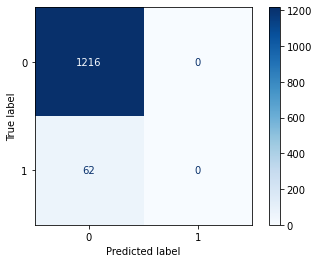

In [155]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logreg_baseline_model, X_test, y_test, cmap = plt.cm.Blues);

In [156]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

def custom_cross_val_score_1(estimator, X, y):
    kfold_train_scores = np.ndarray(5)
    kfold_val_scores = np.ndarray(5)
    kfold = StratifiedKFold(n_splits=5)
    for fold, (train_index, val_index) in enumerate(kfold.split(X, y)):
        X_t, X_val = X.iloc[train_index], X.iloc[val_index]
        y_t, y_val = y.iloc[train_index], y.iloc[val_index]
        scaler = StandardScaler()
        X_t_scaled = scaler.fit_transform(X_t)
        X_val_scaled = scaler.transform(X_val)
        sm = SMOTE(random_state=42, sampling_strategy=0.18)
        X_t_oversampled, y_t_oversampled = sm.fit_resample(X_t_scaled, y_t)
        temp_model = clone(estimator)
        temp_model.fit(X_t_oversampled, y_t_oversampled)
        neg_log_loss_score_train = neg_log_loss(temp_model, X_t_oversampled, y_t_oversampled)
        neg_log_loss_score_val = neg_log_loss(temp_model, X_val_scaled, y_val)
        kfold_train_scores[fold] = neg_log_loss_score_train
        kfold_val_scores[fold] = neg_log_loss_score_val
    return kfold_train_scores, kfold_val_scores

In [157]:
logreg_first_model = LogisticRegression(random_state=42, class_weight={1:0.18})
preprocessed_train_scores, preprocessed_neg_log_loss_cv = custom_cross_val_score_1(
    logreg_first_model,
    X_train,
    y_train)
print("Train:", -preprocessed_train_scores.mean())
print("Validation:", -preprocessed_neg_log_loss_cv.mean())

Train: 0.43000731160103617
Validation: 0.16186854587534225


In [158]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
sm = SMOTE(random_state=42, sampling_strategy=0.20)
X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train_scaled, y_train)

In [159]:
logreg_first_model.fit(X_train_oversampled, y_train_oversampled)
preds_logreg_1 = logreg_first_model.predict(X_test_scaled)
print("Logistic Regression First Model:")
print_metrics(y_test, preds_logreg_1)

Logistic Regression First Model:
Accuracy Score: 0.9514866979655712
Precision Score: 0.0
Recall Score: 0.0


In [107]:
y = one_hot_df['stroke']
X = one_hot_df.drop(columns=['id', 'stroke'], axis=1)

In [108]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
print(y_train.value_counts(),'\n\n', y_test.value_counts())

0    3645
1     187
Name: stroke, dtype: int64 

 0    1216
1      62
Name: stroke, dtype: int64


In [109]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import make_scorer, log_loss

neg_log_loss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
def custom_cross_val_score(estimator, X, y):
    kfold_train_scores = np.ndarray(5)
    kfold_val_scores = np.ndarray(5)
    kfold = StratifiedKFold()
    for fold, (train_index, val_index) in enumerate(kfold.split(X, y)):
        X_t, X_val = X.iloc[train_index], X.iloc[val_index]
        y_t, y_val = y.iloc[train_index], y.iloc[val_index]
        temp_model = clone(estimator)
        temp_model.fit(X_t, y_t)
        neg_log_loss_score_train = neg_log_loss(temp_model, X_t, y_t)
        neg_log_loss_score_val = neg_log_loss(temp_model, X_val, y_val)
        kfold_train_scores[fold] = neg_log_loss_score_train
        kfold_val_scores[fold] = neg_log_loss_score_val
    return kfold_train_scores, kfold_val_scores

In [110]:
logreg_baseline_model = LogisticRegression(random_state=42)
train_scores, neg_log_loss_cv = custom_cross_val_score(
    logreg_baseline_model,
    X_train,
    y_train)
print("Train:", -train_scores.mean())
print("Validation:", -neg_log_loss_cv.mean())

Train: 0.15505982807670962
Validation: 0.16040706939798124


In [111]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

def print_metrics(labels, preds):
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))

In [112]:
logreg_baseline_model.fit(X_train, y_train)
preds_logreg = logreg_baseline_model.predict(X_test)
print("Logistic Regression Baseline Model:")
print_metrics(y_test, preds_logreg)

Logistic Regression Baseline Model:
Accuracy Score: 0.9522691705790297
Precision Score: 1.0
Recall Score: 0.016129032258064516


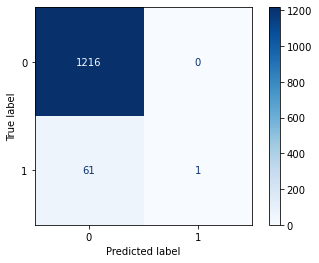

In [104]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logreg_baseline_model, X_test, y_test, cmap = plt.cm.Blues);

In [121]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

def custom_cross_val_score_1(estimator, X, y):
    kfold_train_scores = np.ndarray(5)
    kfold_val_scores = np.ndarray(5)
    kfold = StratifiedKFold(n_splits=5)
    for fold, (train_index, val_index) in enumerate(kfold.split(X, y)):
        X_t, X_val = X.iloc[train_index], X.iloc[val_index]
        y_t, y_val = y.iloc[train_index], y.iloc[val_index]
        scaler = StandardScaler()
        X_t_scaled = scaler.fit_transform(X_t)
        X_val_scaled = scaler.transform(X_val)
        sm = SMOTE(random_state=42, sampling_strategy=0.18)
        X_t_oversampled, y_t_oversampled = sm.fit_resample(X_t_scaled, y_t)
        temp_model = clone(estimator)
        temp_model.fit(X_t_oversampled, y_t_oversampled)
        neg_log_loss_score_train = neg_log_loss(temp_model, X_t_oversampled, y_t_oversampled)
        neg_log_loss_score_val = neg_log_loss(temp_model, X_val_scaled, y_val)
        kfold_train_scores[fold] = neg_log_loss_score_train
        kfold_val_scores[fold] = neg_log_loss_score_val
    return kfold_train_scores, kfold_val_scores

In [122]:
logreg_first_model = LogisticRegression(random_state=42, class_weight={1:0.18})
preprocessed_train_scores, preprocessed_neg_log_loss_cv = custom_cross_val_score_1(
    logreg_first_model,
    X_train,
    y_train)
print("Train:", -preprocessed_train_scores.mean())
print("Validation:", -preprocessed_neg_log_loss_cv.mean())

Train: 0.426769511308561
Validation: 0.16537411938832552


In [123]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
sm = SMOTE(random_state=42, sampling_strategy=0.20)
X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train_scaled, y_train)

In [124]:
logreg_first_model.fit(X_train_oversampled, y_train_oversampled)
preds_logreg_1 = logreg_first_model.predict(X_test_scaled)
print("Logistic Regression First Model:")
print_metrics(y_test, preds_logreg_1)

Logistic Regression First Model:
Accuracy Score: 0.9514866979655712
Precision Score: 0.0
Recall Score: 0.0


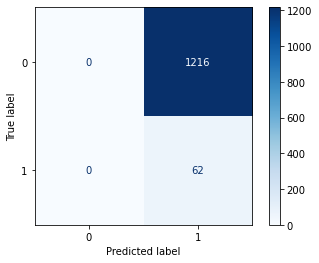

In [125]:
plot_confusion_matrix(logreg_first_model, X_test, y_test, cmap = plt.cm.Blues);

In [15]:
logreg_baseline_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [90]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
knn_baseline_model = KNeighborsClassifier()
knn_baseline_log_loss = cross_val_score(
    knn_baseline_model,
    X_train_scaled,
    y_train,
    scoring='neg_log_loss')
baseline_log_loss = -(knn_baseline_log_loss.mean())
baseline_log_loss

1.0080763567234035

In [69]:
knn_baseline_model.fit(X_train_scaled, y_train)
knn_preds = knn_baseline_model.predict(X_test_scaled)
print("KNN Baseline Model")
print_metrics(y_test, knn_preds)

KNN Baseline Model
Accuracy Score: 0.94679186228482
Precision Score: 0.125
Recall Score: 0.016129032258064516


In [85]:
knn_first_model = KNeighborsClassifier(n_neighbors=100)
knn_first_log_loss = -cross_val_score(
    knn_first_model,
    X_train_scaled,
    y_train,
    scoring='neg_log_loss').mean()
knn_first_log_loss

0.1956280342956694

In [83]:
knn_second_model = KNeighborsClassifier(n_neighbors=200)
knn_second_log_loss = -cross_val_score(
    knn_second_model,
    X_train_scaled,
    y_train,
    scoring='neg_log_loss').mean()
knn_second_log_loss

0.17963303643794215

In [86]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=100, max_k=200):
    best_k = 0
    best_score = 1.00
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        log_loss = -cross_val_score(
            knn,
            X_train,
            y_train, 
            scoring='neg_log_loss').mean()
        if log_loss < best_score:
            best_k = k
            best_score = log_loss
    print("Best Value for k: {}".format(best_k))
    print("Log Loss: {}".format(best_score))

In [87]:
find_best_k(X_train_scaled, y_train, X_test_scaled, y_test)

Best Value for k: 144
Log Loss: 0.17923810210065388


In [88]:
knn_best_model = KNeighborsClassifier(n_neighbors=144)
knn_best_log_loss = -cross_val_score(
    knn_best_model,
    X_train_scaled,
    y_train,
    scoring='neg_log_loss').mean()
print(knn_second_log_loss)
knn_best_model.fit(X_train_scaled, y_train)
preds = knn_best_model.predict(X_test_scaled)
print_metrics(y_test, preds)

0.17963303643794215
Accuracy Score: 0.9514866979655712
Precision Score: 0.0
Recall Score: 0.0
